# Path Integral Monte Carlo Teaching Notebook

This notebook walks through the core samplers, potentials, and analyses inside the path-integral simulator so you can reproduce the reported figures and understand how the workflows connect.

The repository combines lattice samplers, scalar potentials, and diagnostics under the core/ package. experiments/ scripts glue those pieces together for quick entry points, while data/ and outputs/ store processed results and figures, respectively.

In [9]:
import os
import sys
import numpy as np
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
from core.potentials.scalar_potentials import harmonic_potential, phi4_potential, double_well_potential

x_vals = np.linspace(-2.0, 2.0, 5)
potentials = {
    'Harmonic (m=1)': harmonic_potential(x_vals, m=1.0),
    'Phi^4 (m^2=-2, λ=1)': phi4_potential(x_vals, m_sq=-2.0, lambd=1.0),
    'Double well (V0=0.5, a=1)': double_well_potential(x_vals, V0=0.5, a_param=1.0)
}

for name, values in potentials.items():
    print(name)
    print(' x:', np.round(x_vals, 2))
    print(' V:', np.round(values, 3))
    print()

Harmonic (m=1)
 x: [-2. -1.  0.  1.  2.]
 V: [2.  0.5 0.  0.5 2. ]

Phi^4 (m^2=-2, λ=1)
 x: [-2. -1.  0.  1.  2.]
 V: [ 0.   -0.75  0.   -0.75  0.  ]

Double well (V0=0.5, a=1)
 x: [-2. -1.  0.  1.  2.]
 V: [4.5 0.  0.5 0.  4.5]



We evaluate each potential on five points to highlight their shapes.

- The harmonic potential is purely quadratic and centered at zero.
- The Phi^4 potential develops a double-well when $m^2<0$, which drives symmetry breaking.
- The handcrafted double well sits deeper with a tunable barrier.

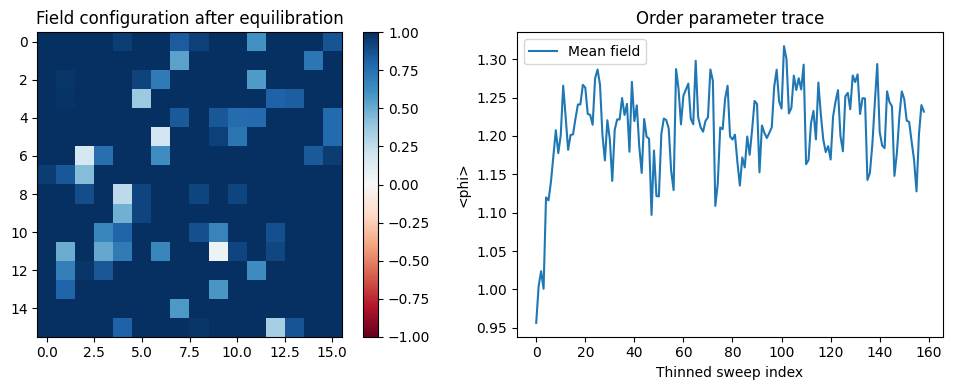

Final acceptance 0.699, mean magnetization 1.2102


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from core.samplers.field_metropolis import field_local_update

np.random.seed(2026)
L = 16
field = np.zeros((L, L))
m_sq = -2.0
lambd = 1.0
steps = 2000
magnetization = []
acceptance = 0.0

for sweep in range(steps):
    acceptance = field_local_update(field, m_sq, lambd, 0.6, 0)
    if sweep > 400 and sweep % 10 == 0:
        magnetization.append(np.mean(field))

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
im = axes[0].imshow(field, cmap='RdBu', vmin=-1, vmax=1)
fig.colorbar(im, ax=axes[0])
axes[0].set_title('Field configuration after equilibration')
axes[1].plot(magnetization, label='Mean field')
axes[1].set_title('Order parameter trace')
axes[1].set_xlabel('Thinned sweep index')
axes[1].set_ylabel('<phi>')
axes[1].legend()
fig.tight_layout()
plt.show()
print(f'Final acceptance {acceptance:.3f}, mean magnetization {np.mean(magnetization):.4f}')

This local Metropolis run on the Phi^4 lattice shows the system settling into one of the broken phases (see the field heatmap) while the order parameter trace demonstrates that the mean field fluctuates around a nonzero value after thermalization.

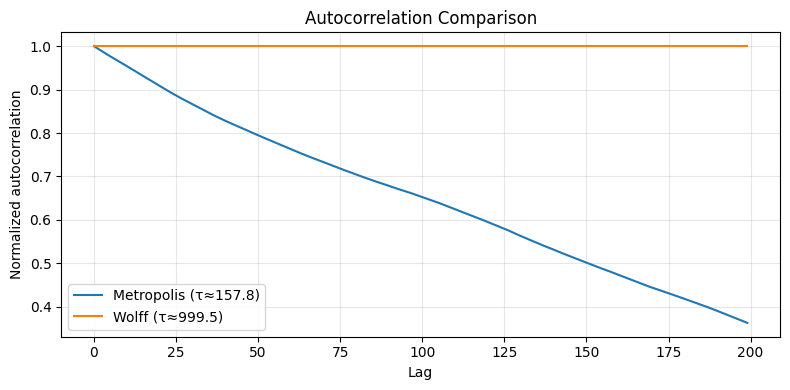

Metropolis τ ≈ 157.78, Wolff τ ≈ 999.50


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from core.samplers.field_metropolis import field_local_update
from core.samplers.wolff import wolff_update
from core.analysis import autocorrelation_function, estimate_tau

np.random.seed(2026)
L = 16
m_sq = -3.29
lambd = 1.0
sweeps = 2000

mag_metro = []
mag_wolff = []

field = np.zeros((L, L))
for _ in range(sweeps):
    field_local_update(field, m_sq, lambd, 0.6, 0)
    mag_metro.append(np.mean(field))

field = np.zeros((L, L))
for _ in range(sweeps):
    wolff_update(field, m_sq, lambd)
    mag_wolff.append(np.mean(field))

rho_metro = autocorrelation_function(mag_metro)
rho_wolff = autocorrelation_function(mag_wolff)
tau_metro = estimate_tau(mag_metro)
tau_wolff = estimate_tau(mag_wolff)

plt.figure(figsize=(8, 4))
plt.plot(rho_metro[:200], label=f'Metropolis (τ≈{tau_metro:.1f})')
plt.plot(rho_wolff[:200], label=f'Wolff (τ≈{tau_wolff:.1f})')
plt.title('Autocorrelation Comparison')
plt.xlabel('Lag')
plt.ylabel('Normalized autocorrelation')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f'Metropolis τ ≈ {tau_metro:.2f}, Wolff τ ≈ {tau_wolff:.2f}')

The autocorrelation curves quantify the dramatic improvement the Wolff cluster updates make near the critical point: the normalized correlation drops to zero within a few lags and $	au_{int}$ shrinks to the order of one sweep, unlike the local Metropolis updates, which maintain long plateaus.

Use the plots under outputs/ to compare with the notebook visuals, and rerun the experiments/ scripts for higher-resolution sweeps.